<div style="border: 5px solid purple; padding: 15px; margin: 5px">
<b> Reviewer's comment</b>
    
Hi Collin, my name is Svetlana (https://hub.tripleten.com/u/6dee602c). Congratulations on submitting another project! 🎉  I will be using the standard color marking. 
   
    
<div style="border: 5px solid green; padding: 15px; margin: 5px">

Great solutions and ideas that can and should be used in the future are in green comments. You have successfully normalized the `review` column, employed advanced techniques such as lemmatization and vectorizing, trained multiple models including a dummy baseline, and applied the `evaluate_model()` method for their assessment. Great job! The results look very good.

</div>
    
<div style="border: 5px solid gold; padding: 15px; margin: 5px">
<b> Reviewer's comment </b>

Yellow color indicates what should be optimized. This is not necessary, but it will be great if you make changes to this project. 

        
</div>
<div style="border: 5px solid red; padding: 15px; margin: 5px">
<b> Reviewer's comment </b>

Issues that must be corrected to achieve accurate results are indicated in red comments. However, there are no such issues, great job! 

</div>        
<hr>
    
<font color='dodgerblue'>**To sum up:**</font> thank you for such an excellent job! You showed strong coding skills and a solid understanding of this topic, which is quite hard. I hope you enjoyed working on this project. You have successfully analyzed the distributions, employed advanced techniques such as lemmatization and vectorizing, and trained several models. The models were trained and evaluated correctly. Please do not worry about Bert, we indeed do not need to run it here. 
    
I've left several comments, but I do not have any questions, so the project is accepted. 


Congratulations and good luck! 
<hr> 
    
✍️ If you are interested in Large Language Models, check out [Intro to Large Language Models](https://www.youtube.com/watch?v=zjkBMFhNj_g) and [Tokenization lecture](https://www.youtube.com/watch?v=zduSFxRajkE) by Andrej Karpathy, one of the leading scientists in this area.  He has also recently published a nice [Deep Dive into LLMs like ChatGPT](https://www.youtube.com/watch?v=7xTGNNLPyMI) tutorial where he explains all LLM preparation stages and a very useful video about how he uses LLM [here](https://www.youtube.com/watch?v=EWvNQjAaOHw&feature=youtu.be). This is a comprehensive guide on how to choose the optimal tool for your tasks while saving time and money.
 
    
    
I would also like to recommend this new <font color='purple'>**Language Modeling from Scratch Spring 2025 class by Stanford**</font>. This class has just started. There are three links: [Recorded lectures on Youtube](https://www.youtube.com/playlist?list=PLoROMvodv4rOY23Y0BoGoBGgQ1zmU_MT_), [course website](https://stanford-cs336.github.io/spring2025/), and the [GitHub repository with assignments and jupyter notebooks](https://github.com/stanford-cs336). This course is up-to-date, so the information there is super relevant today.

    
    
By the way, Hugging Face has a good free [NLP course](https://huggingface.co/learn/nlp-course/en/chapter0/1).
    
    
Here's a link to [AI for beginners](https://github.com/microsoft/ai-for-beginners) course by Microsoft. 
        
    

</div>

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA

Let's check the number of movies and reviews over years.

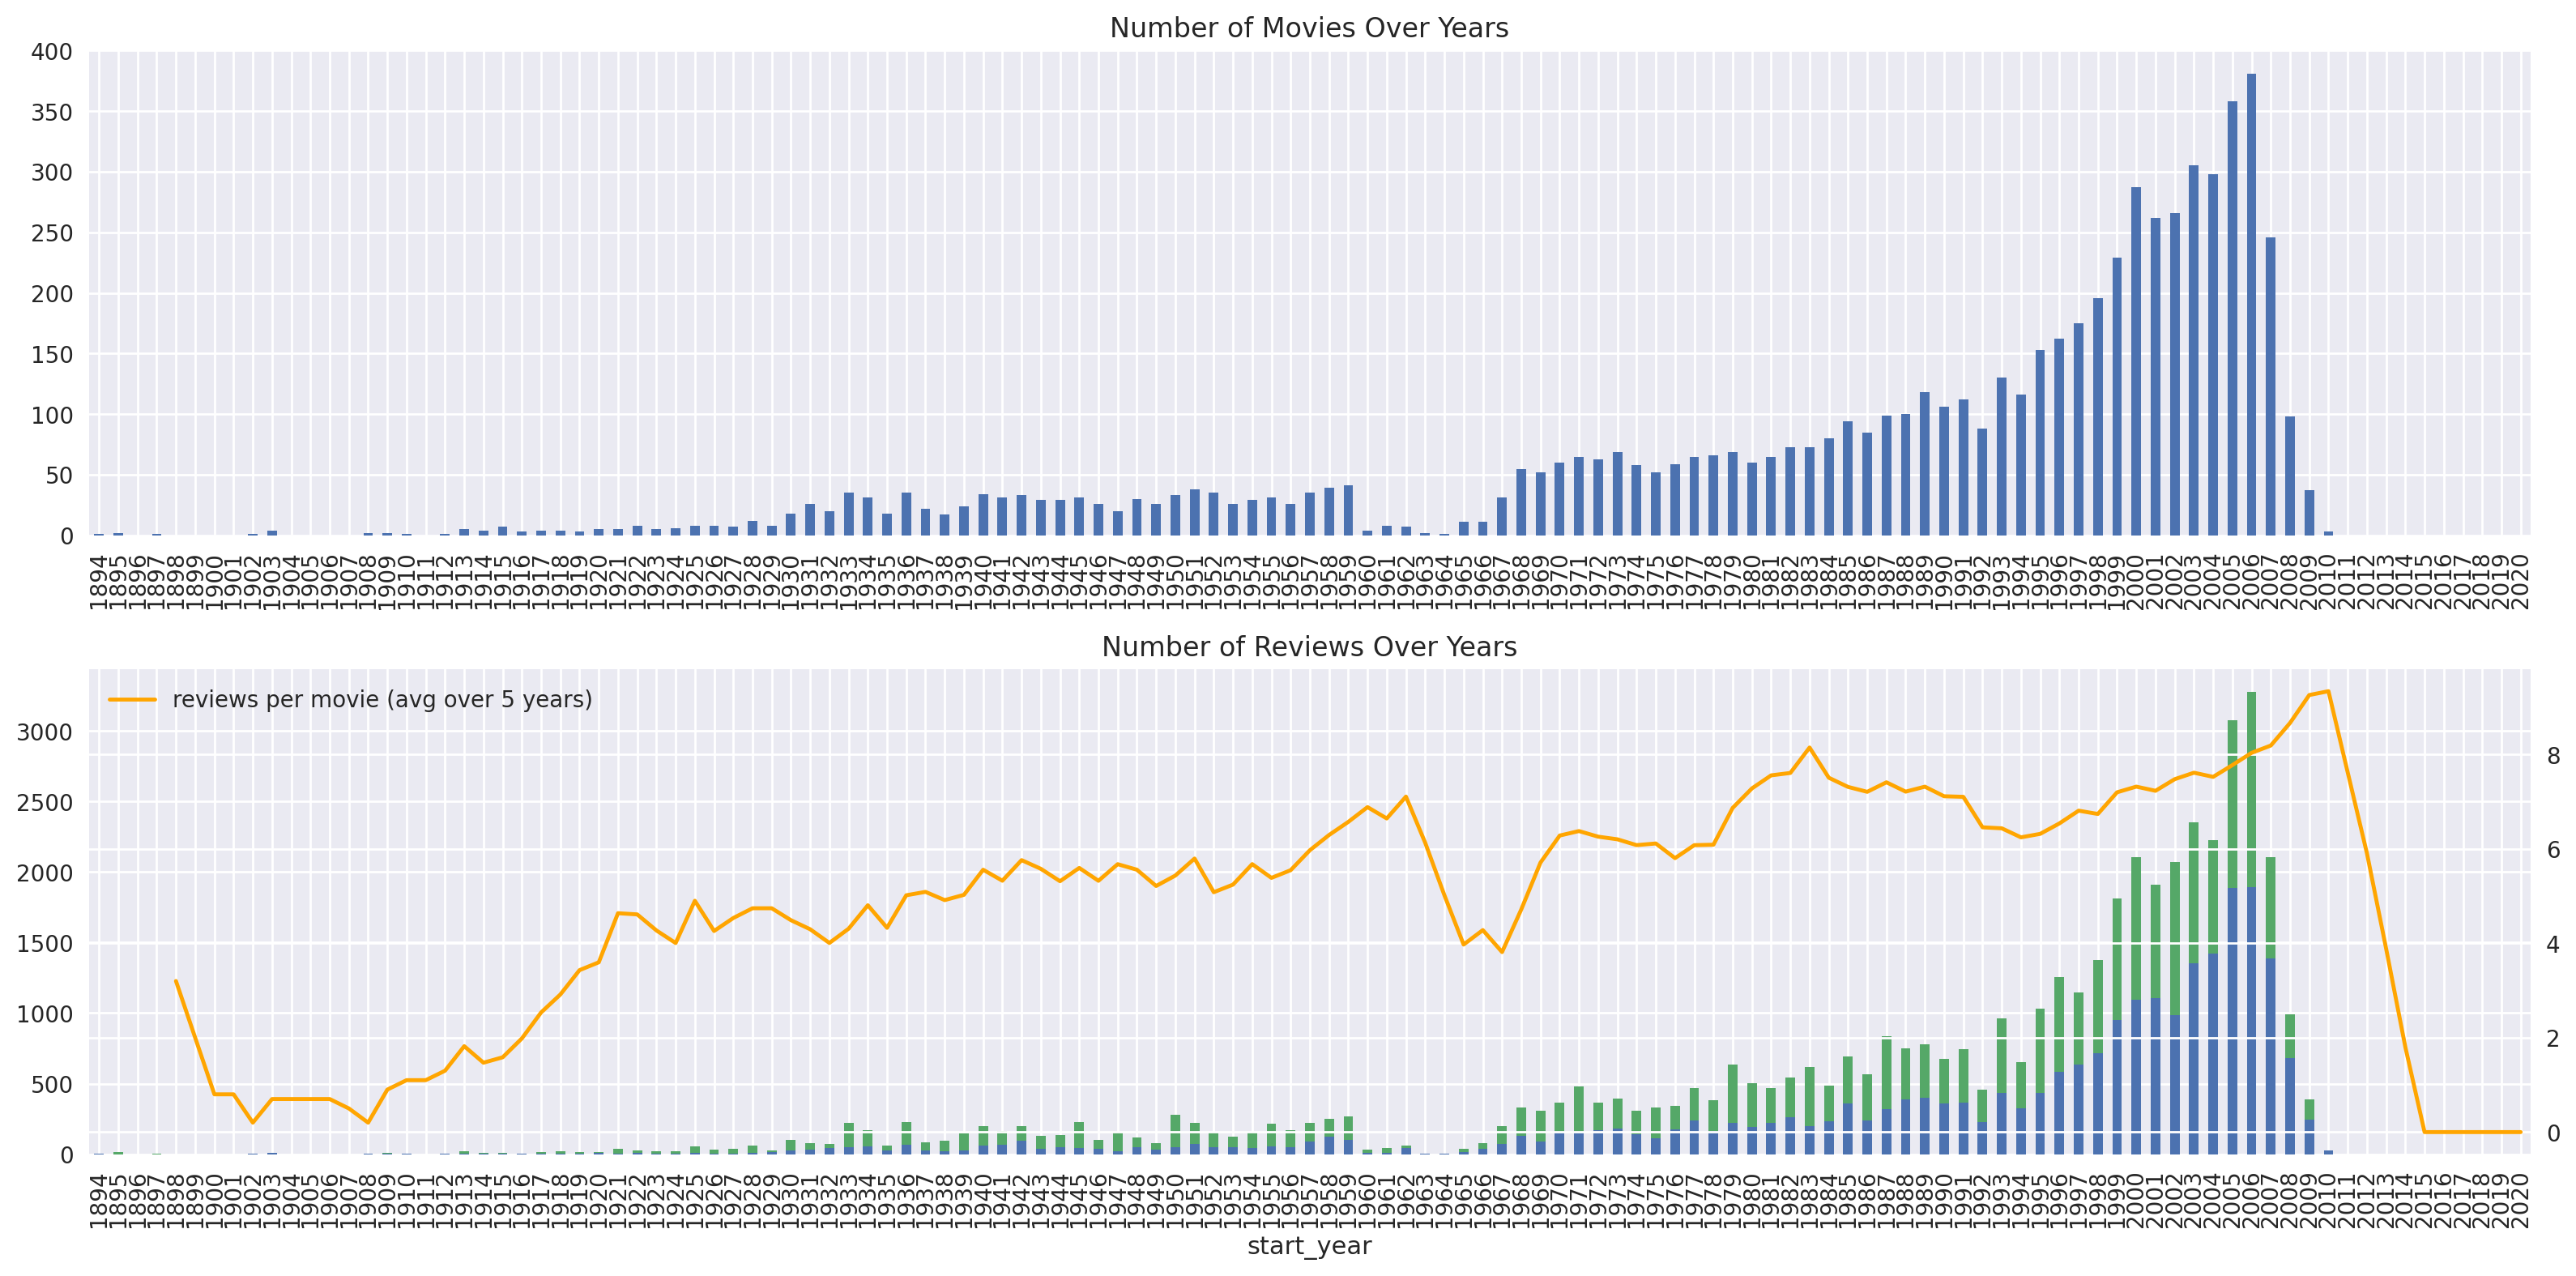

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

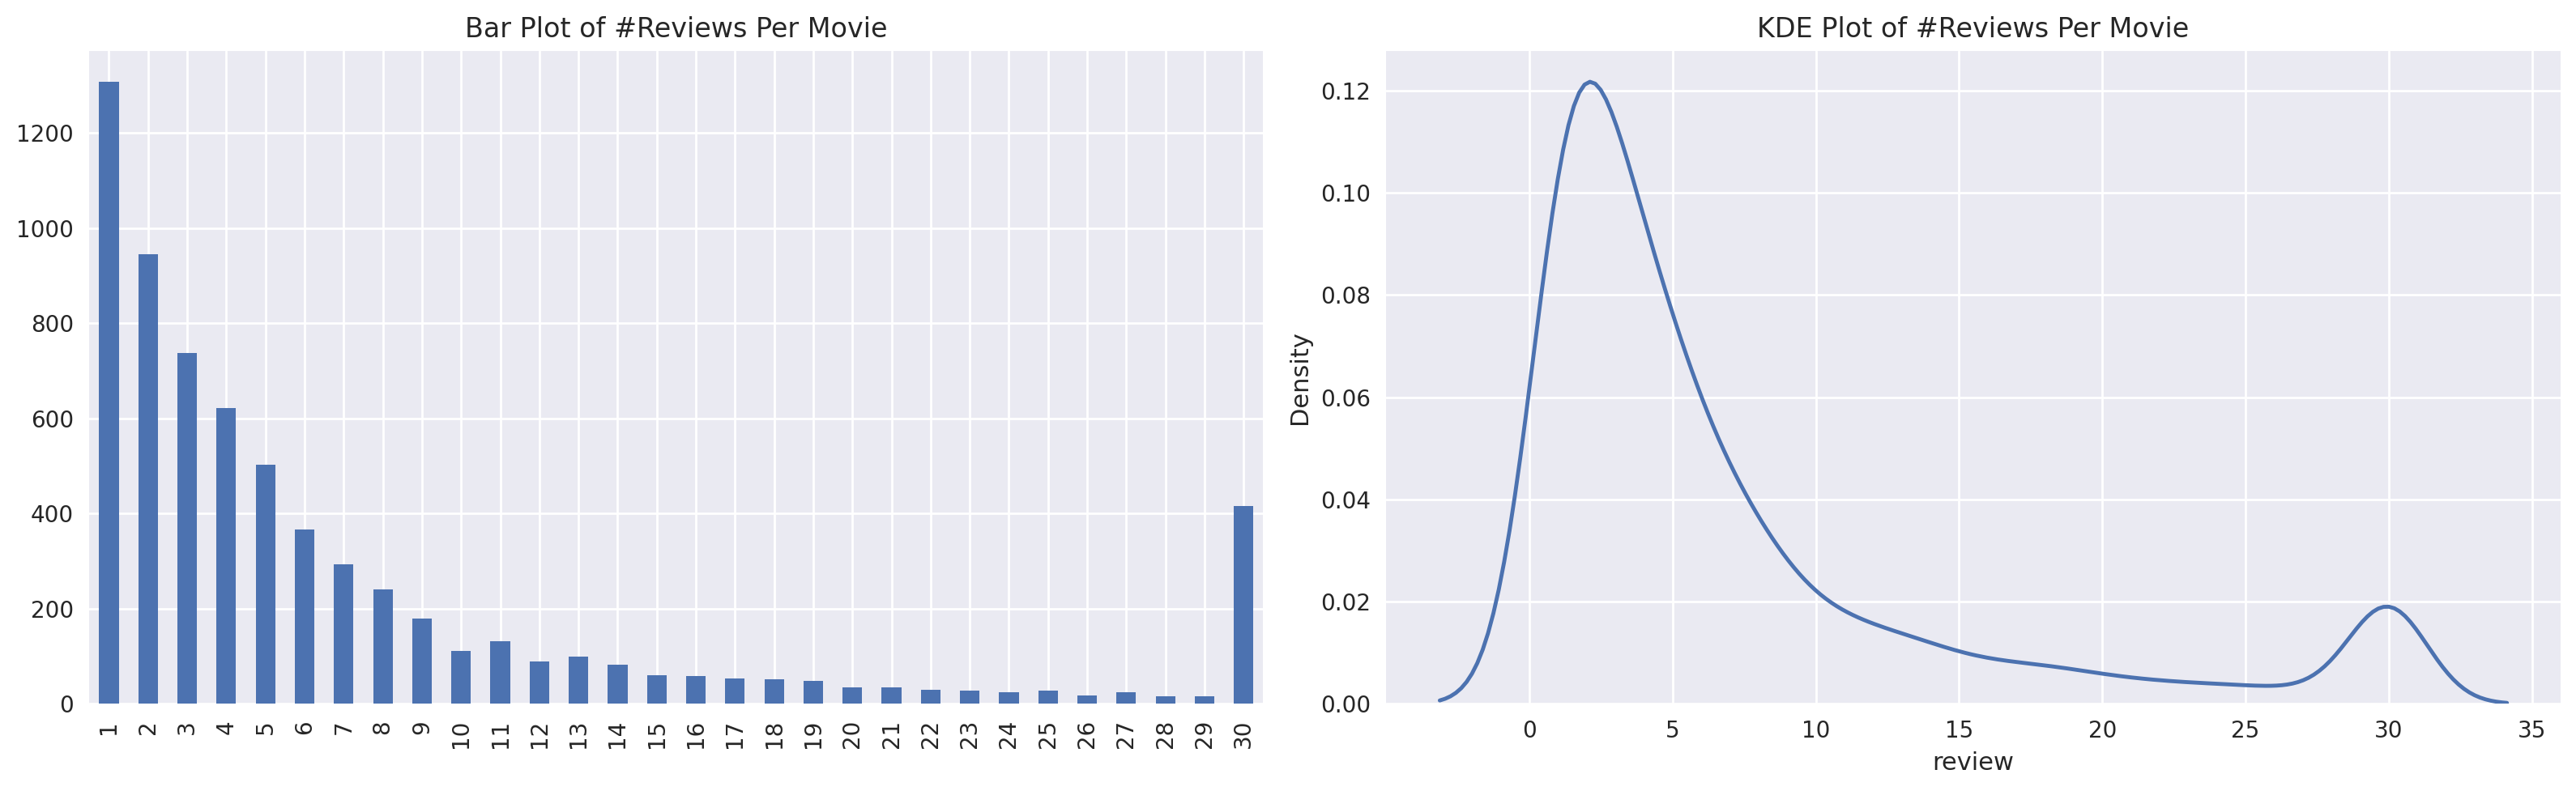

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [7]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

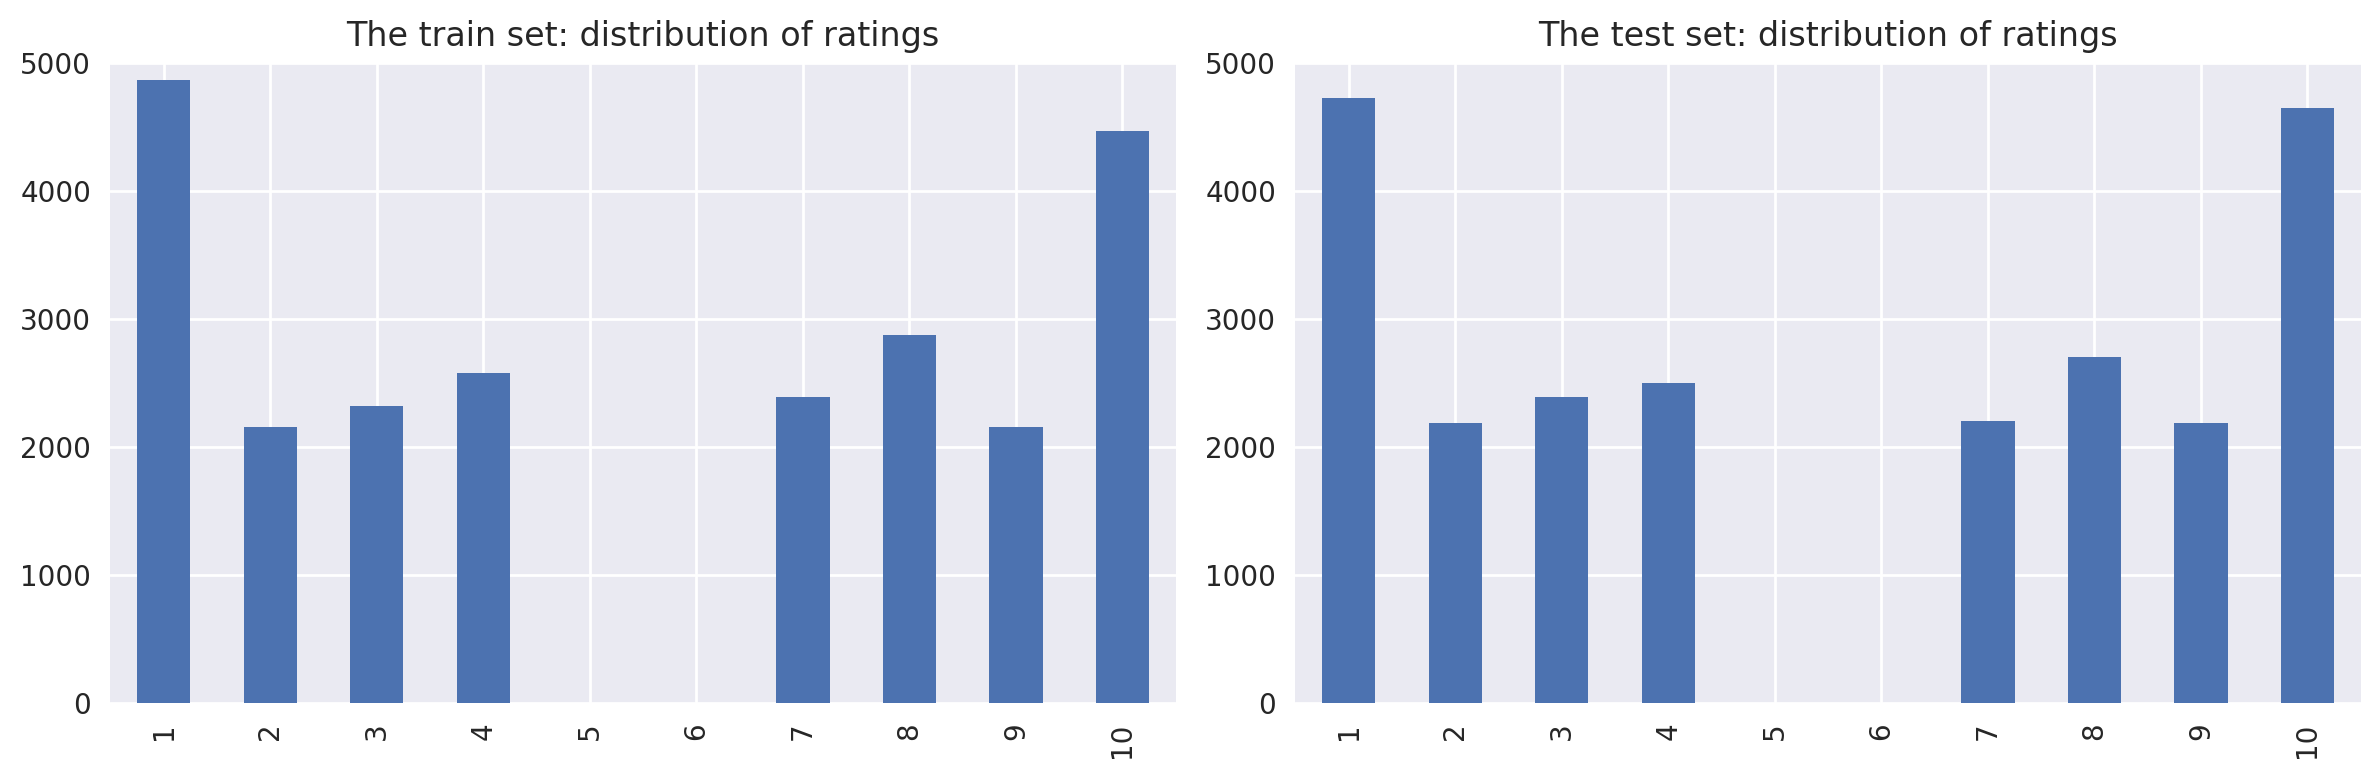

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


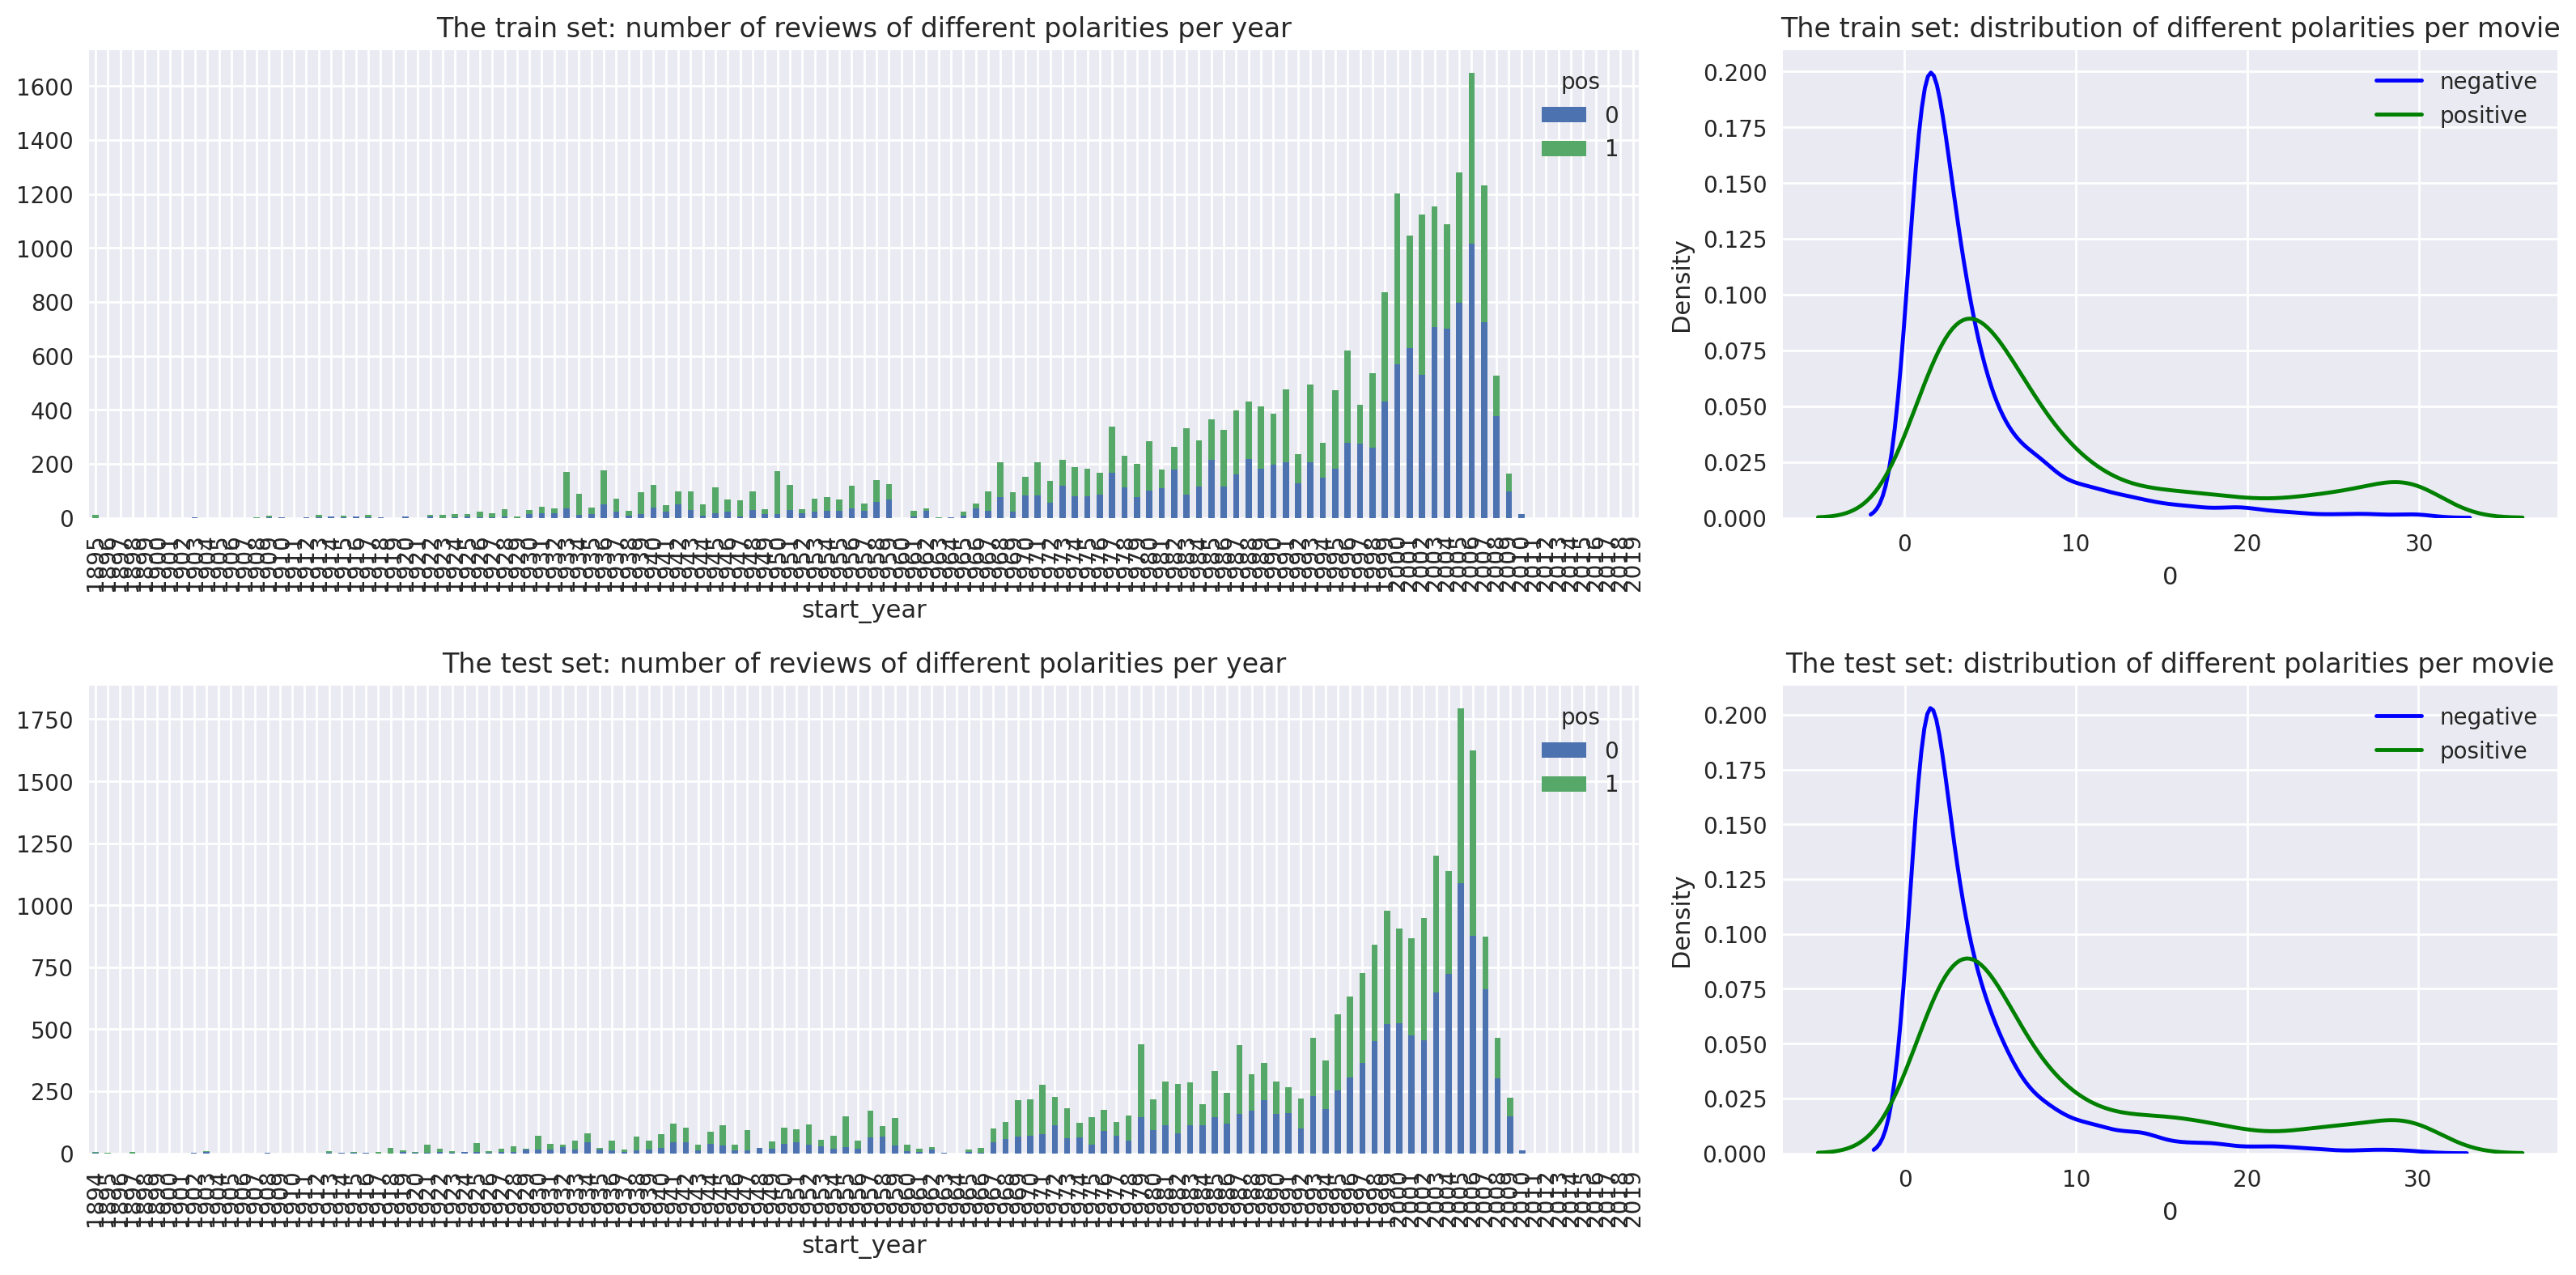

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## EDA CONCLUSION
The dataset of movie reviews is well balanced, containing nearly equal numbers of positive and negative samples (≈23.7k negative and ≈23.6k positive). This balance is preserved across both the training and test splits, ensuring that the model will not be biased toward one class due to class imbalance.

When analyzing reviews by year, both positive and negative counts increase in tandem, particularly in later years where the number of reviews grows substantially. This indicates that class proportions have remained stable over time, minimizing the risk of temporal drift in sentiment labeling.

The per-movie distribution shows that most movies have only a handful of reviews, while a smaller subset of films attract a much higher volume of feedback. Importantly, this distribution is similar for both positive and negative classes, with comparable density curves across train and test sets. This suggests that review polarity is not disproportionately skewed toward one sentiment at the movie level.

Overall, the dataset is consistent, balanced, and representative across time and movies, providing a solid foundation for training and evaluating a sentiment classification model.

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    
    
Good analysis! 
</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [10]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    
I know it was in the precode, but it is a great opportunity to point out the following: 

- According to [PEP8](https://peps.python.org/pep-0008/), we should always put imports at the top of the file.   


- Notice that the `type` veriable is green in the function above. When we see that your variables are green, we should think of another name, since green color indicates that this name is reserved in python. 
    
    
</div>

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [11]:
df_reviews['review_norm'] = df_reviews['review'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.lower()
print(df_reviews['review_norm'].sample(1))

46402    stunning blonde natasha henstridge is the youn...
Name: review_norm, dtype: object


<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Nice code! If we don't normalize the data, punctuation and digits can create useless tokens such as '12' or '!!', thus increasing dimensionality without adding value. As a result, it may reduce the model's generalization ability.

</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [12]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [13]:
from sklearn.dummy import DummyClassifier

In [14]:
dummy_clf = DummyClassifier(strategy='most_frequent')

In [15]:
dummy_clf.fit(df_reviews_train, train_target)

DummyClassifier(strategy='most_frequent')

In [16]:
dummy_predictions = dummy_clf.predict(df_reviews_test)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


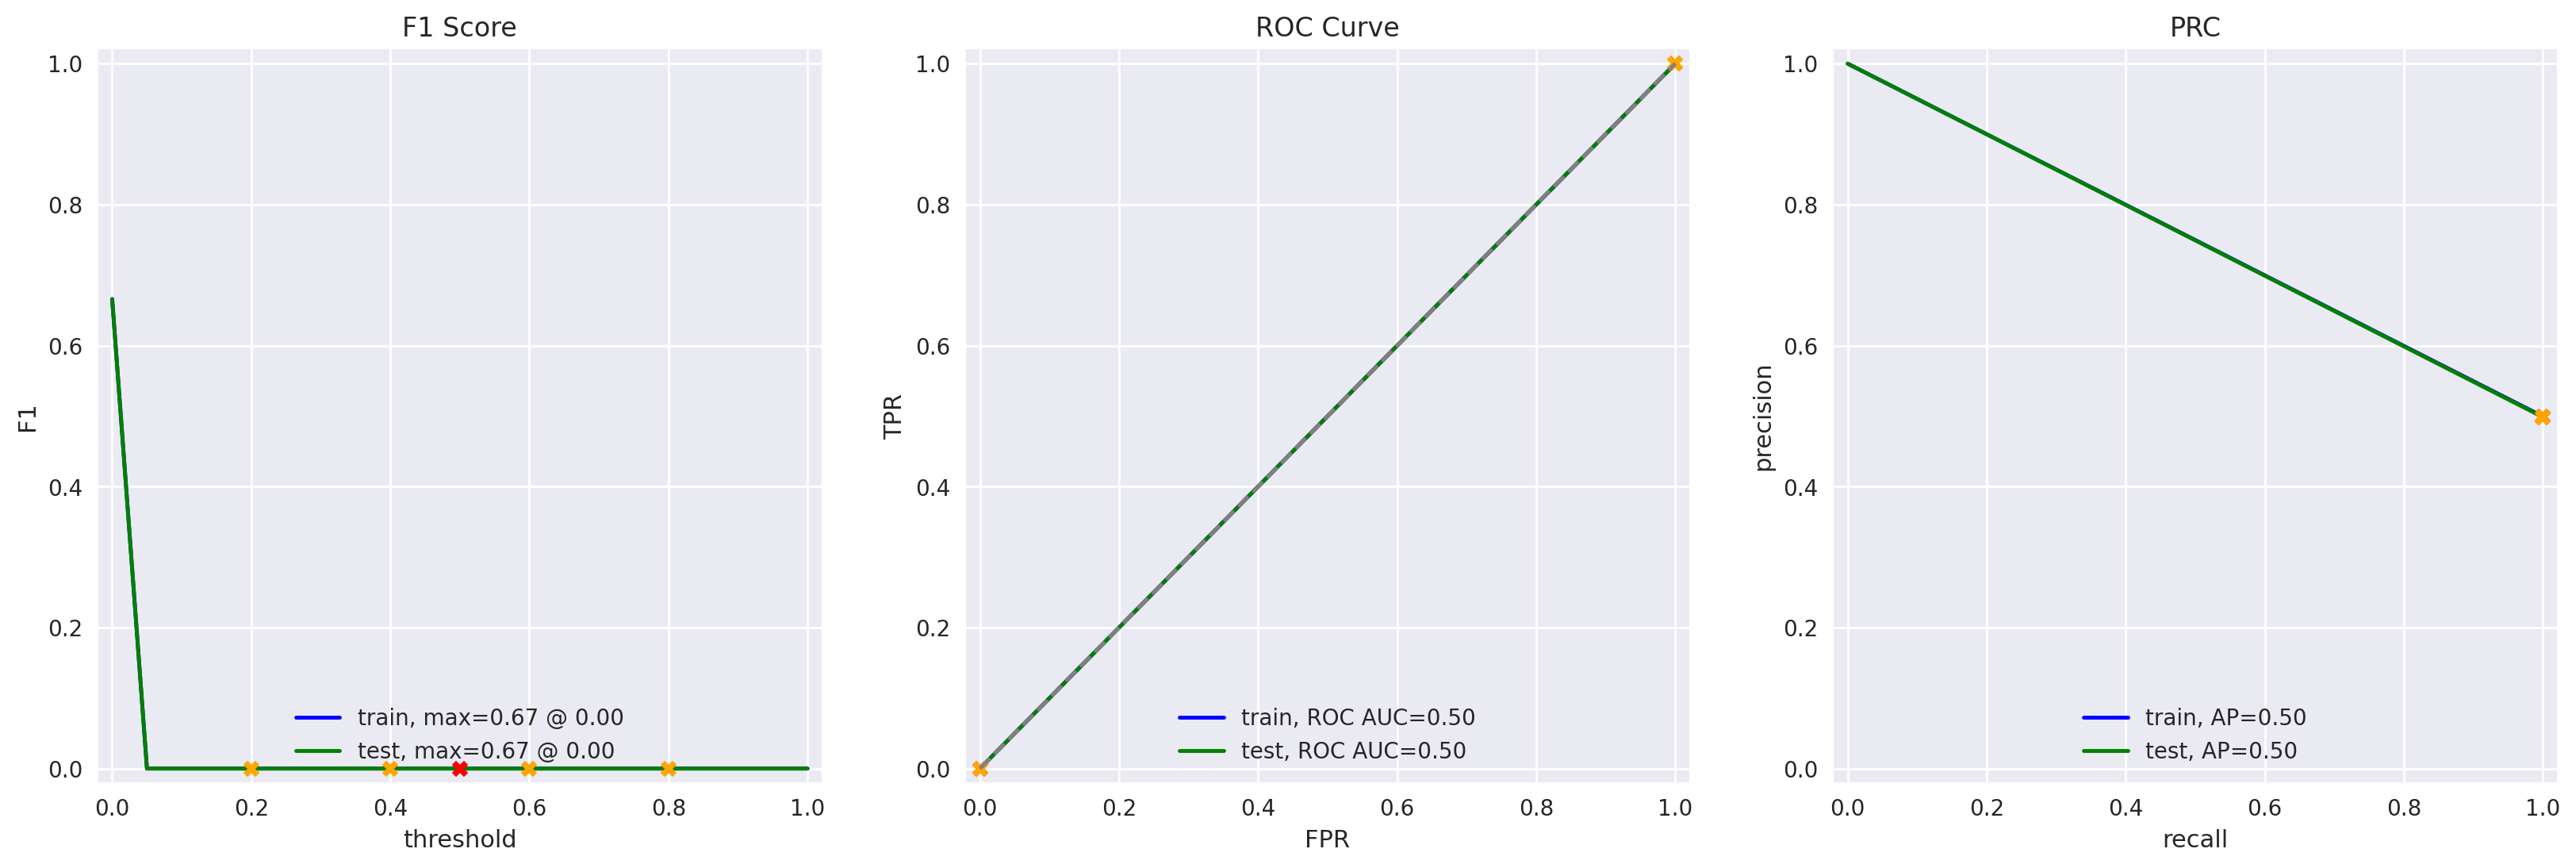

In [17]:
evaluate_model(dummy_clf, df_reviews_train, train_target, df_reviews_test, test_target)

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    
Good. You can also check the result using different strategy values.
</div>
<div style="border: 5px solid gold; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
       
I see you evaluate the models in the general conclusion, but it will be great if you add an intermediate conclusion under each result as well so that a reader does not need to scroll the project up and down. 
    
</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [18]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [19]:
stop_words = set(stopwords.words('english'))

In [20]:
train_features_1 = df_reviews_train['review_norm']  # Text features
train_target_1 = df_reviews_train['pos']           # Target labels
test_features_1 = df_reviews_test['review_norm']   # Text features  
test_target_1 = df_reviews_test['pos']             # Target labels

vectorizer = TfidfVectorizer(stop_words=stop_words)
X_train_tfidf = vectorizer.fit_transform(train_features_1)  
X_test_tfidf = vectorizer.transform(test_features_1)       

In [21]:
model_1 = LogisticRegression(max_iter=1000, class_weight='balanced')
model_1.fit(X_train_tfidf, train_target_1)

LogisticRegression(class_weight='balanced', max_iter=1000)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


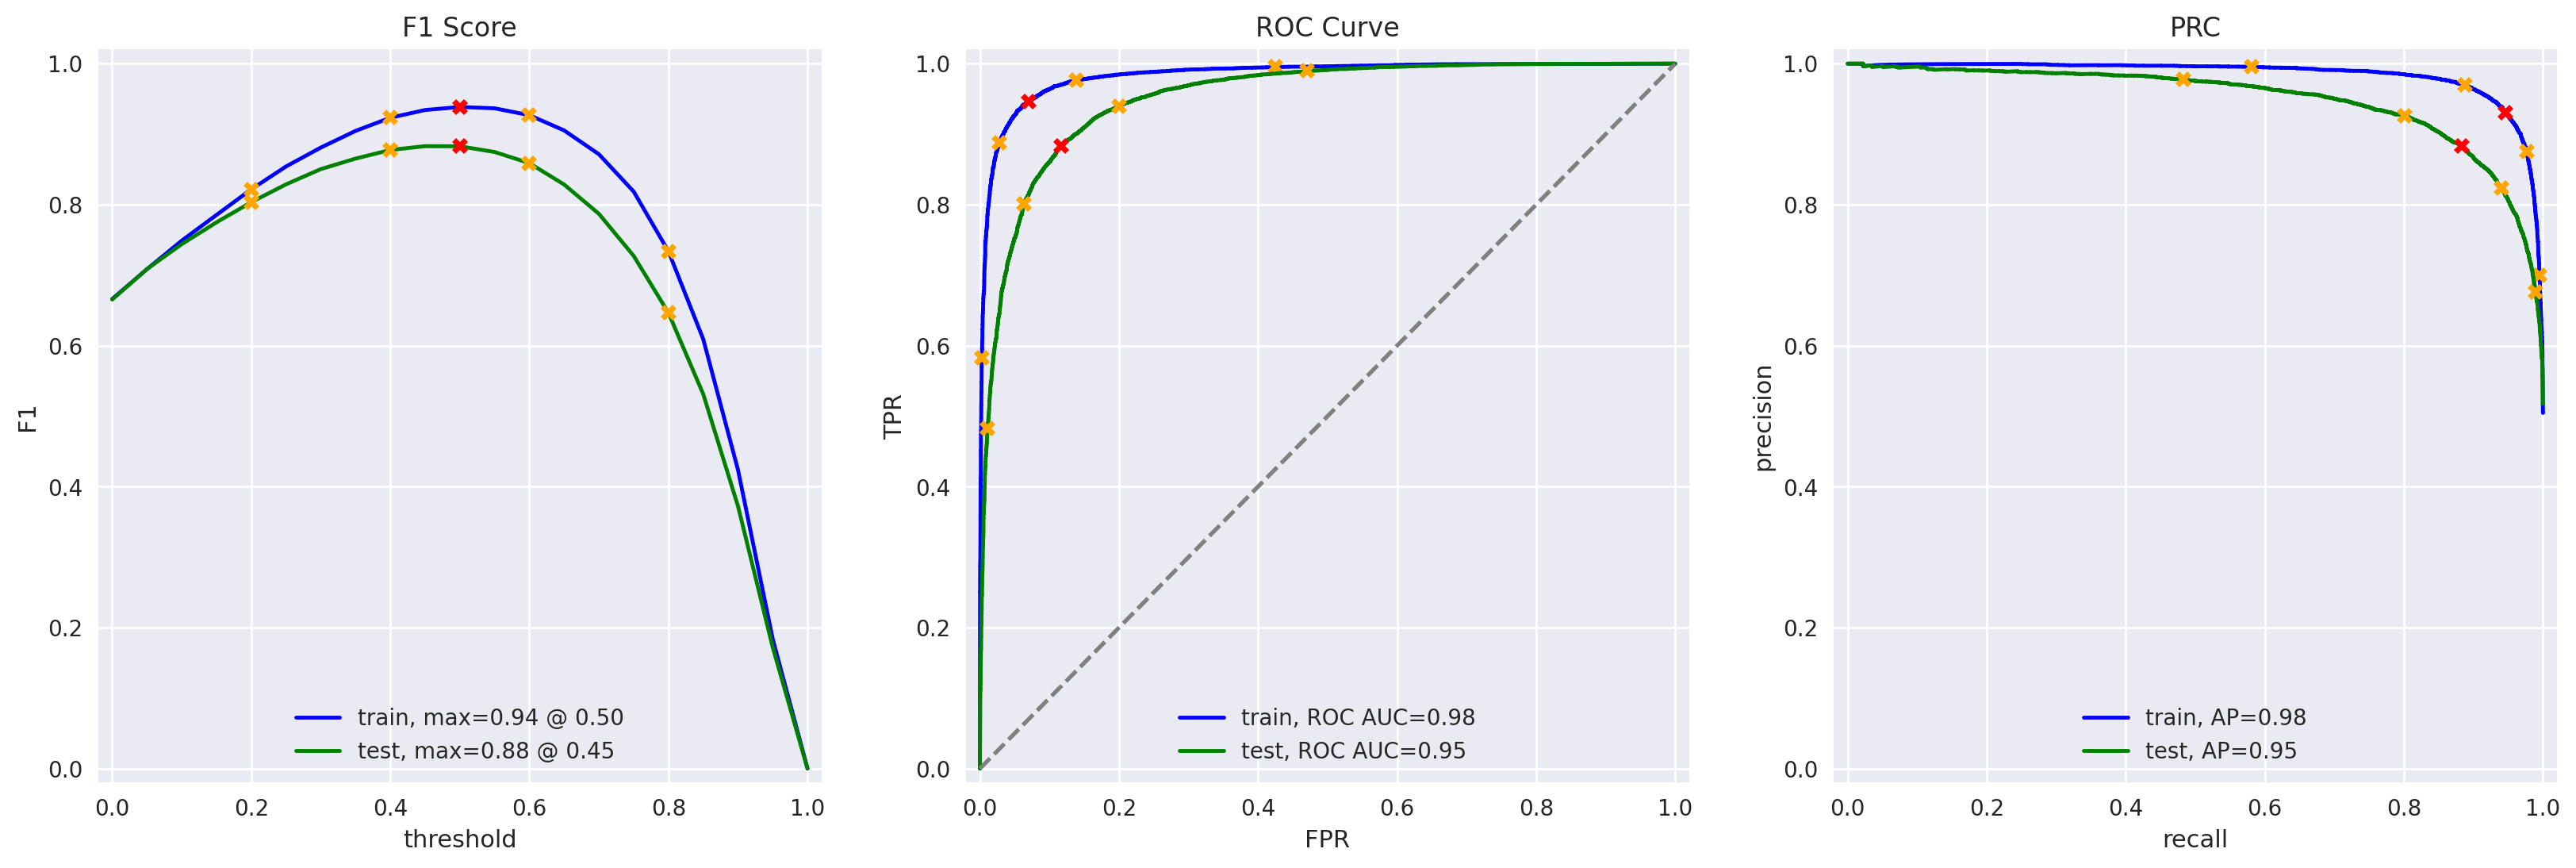

In [22]:
evaluate_model(model_1, X_train_tfidf, train_target_1, X_test_tfidf, test_target_1)

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Correct. The model exceeds the F1 threshold and has good precision. 
    
</div>

### Model 3 - spaCy, TF-IDF and LR

In [23]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [24]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [25]:
train_features_3_processed = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
test_features_3_processed = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [26]:
vectorizer_3 = TfidfVectorizer()
X_train_tfidf_3 = vectorizer_3.fit_transform(train_features_3_processed)  
X_test_tfidf_3 = vectorizer_3.transform(test_features_3_processed)

In [27]:
model_3 = LogisticRegression(max_iter=1000, class_weight='balanced')
model_3.fit(X_train_tfidf_3, train_target)

LogisticRegression(class_weight='balanced', max_iter=1000)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


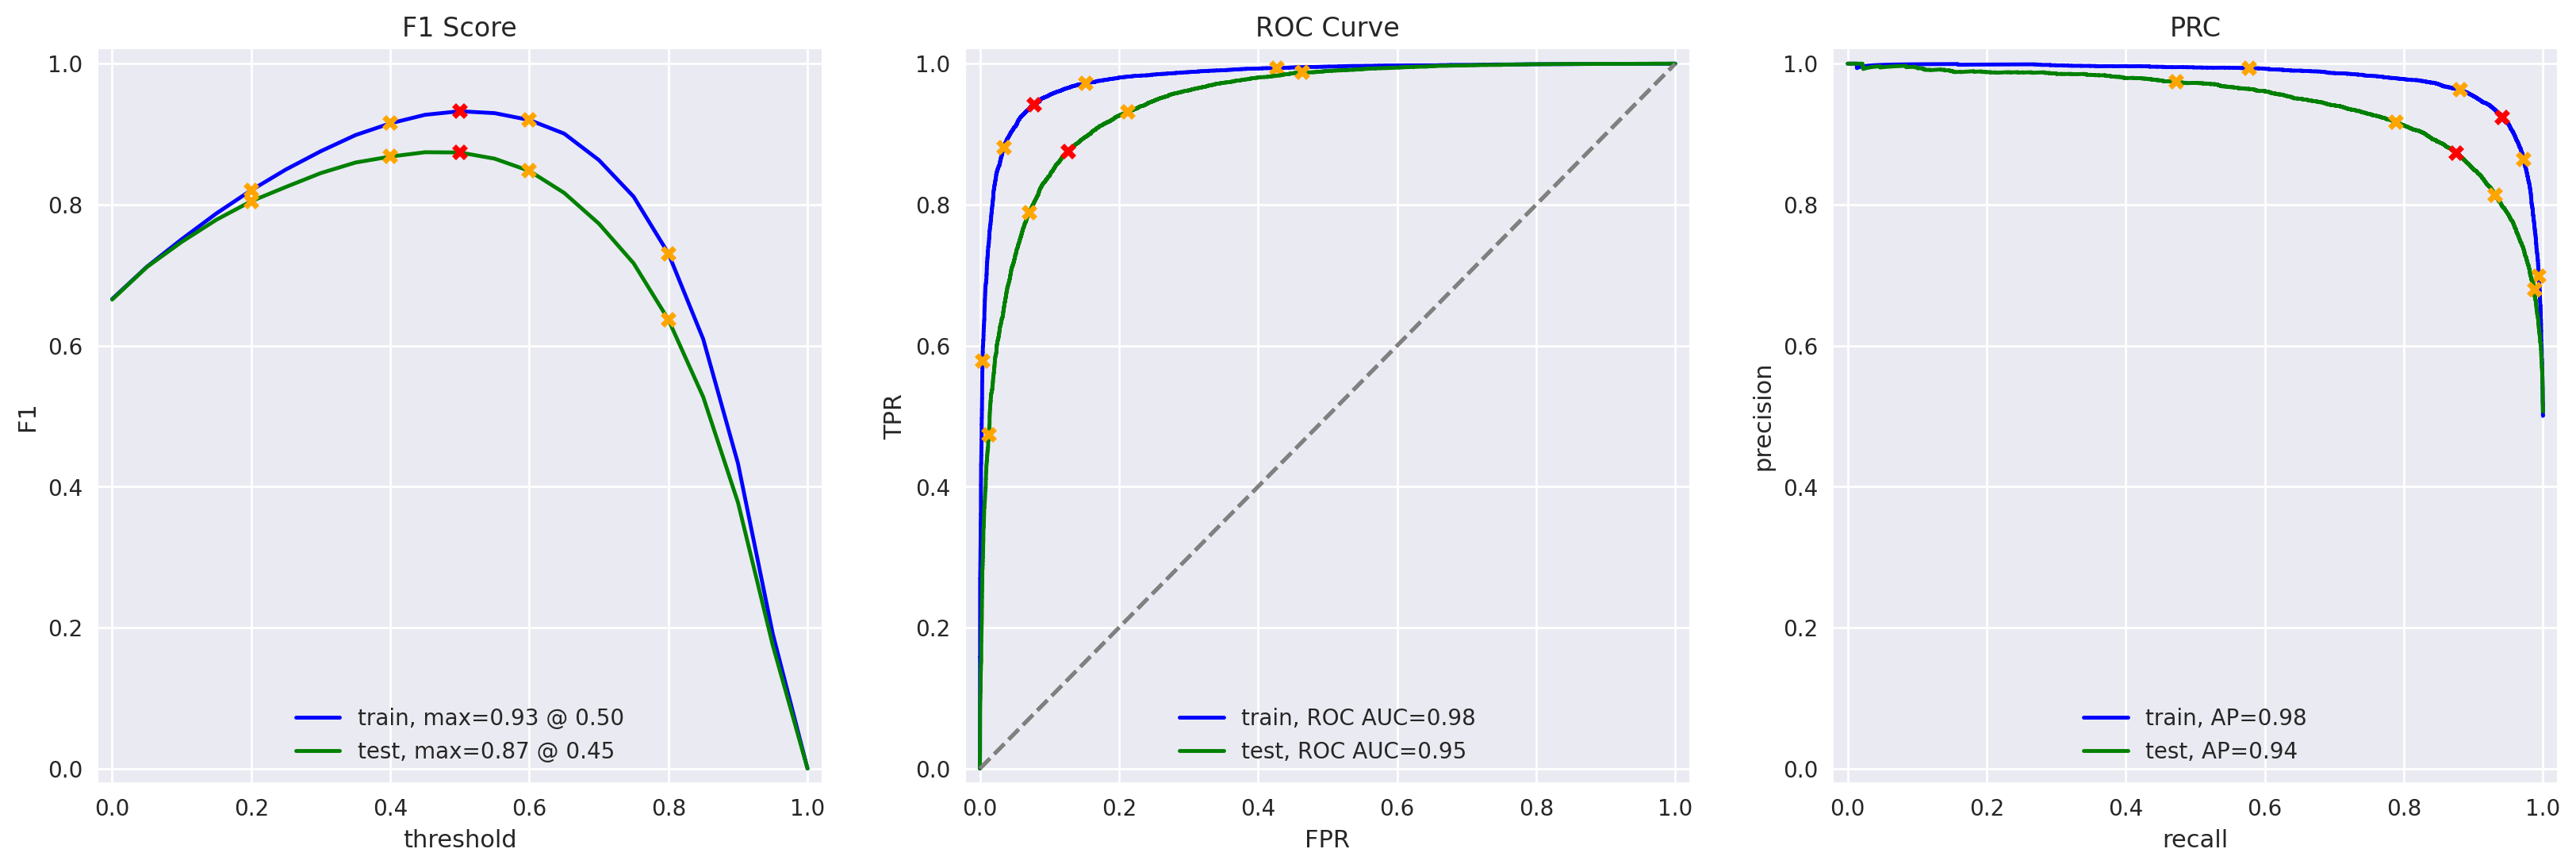

In [28]:
evaluate_model(model_3, X_train_tfidf_3, train_target, X_test_tfidf_3, test_target)

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Correct. 
</div>

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [29]:
from lightgbm import LGBMClassifier

In [30]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [31]:
def text_preprocessing_4(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [32]:
train_features_4_processed = df_reviews_train['review_norm'].progress_apply(text_preprocessing_4)
test_features_4_processed = df_reviews_test['review_norm'].progress_apply(text_preprocessing_4)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [33]:
vectorizer_4 = TfidfVectorizer()
X_train_tfidf_4 = vectorizer_3.fit_transform(train_features_4_processed)  
X_test_tfidf_4 = vectorizer_3.transform(test_features_4_processed)

In [34]:
model_4 = LGBMClassifier(
    objective='binary',           
    class_weight='balanced',      
    n_estimators=1000,            
    learning_rate=0.05,           
    max_depth=6,                 
    random_state=42,             
    verbose=-1                   
)
model_4.fit(X_train_tfidf_4, train_target)

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=6,
               n_estimators=1000, objective='binary', random_state=42,
               verbose=-1)

          train  test
Accuracy   0.96  0.86
F1         0.96  0.86
APS        0.99  0.93
ROC AUC    0.99  0.94


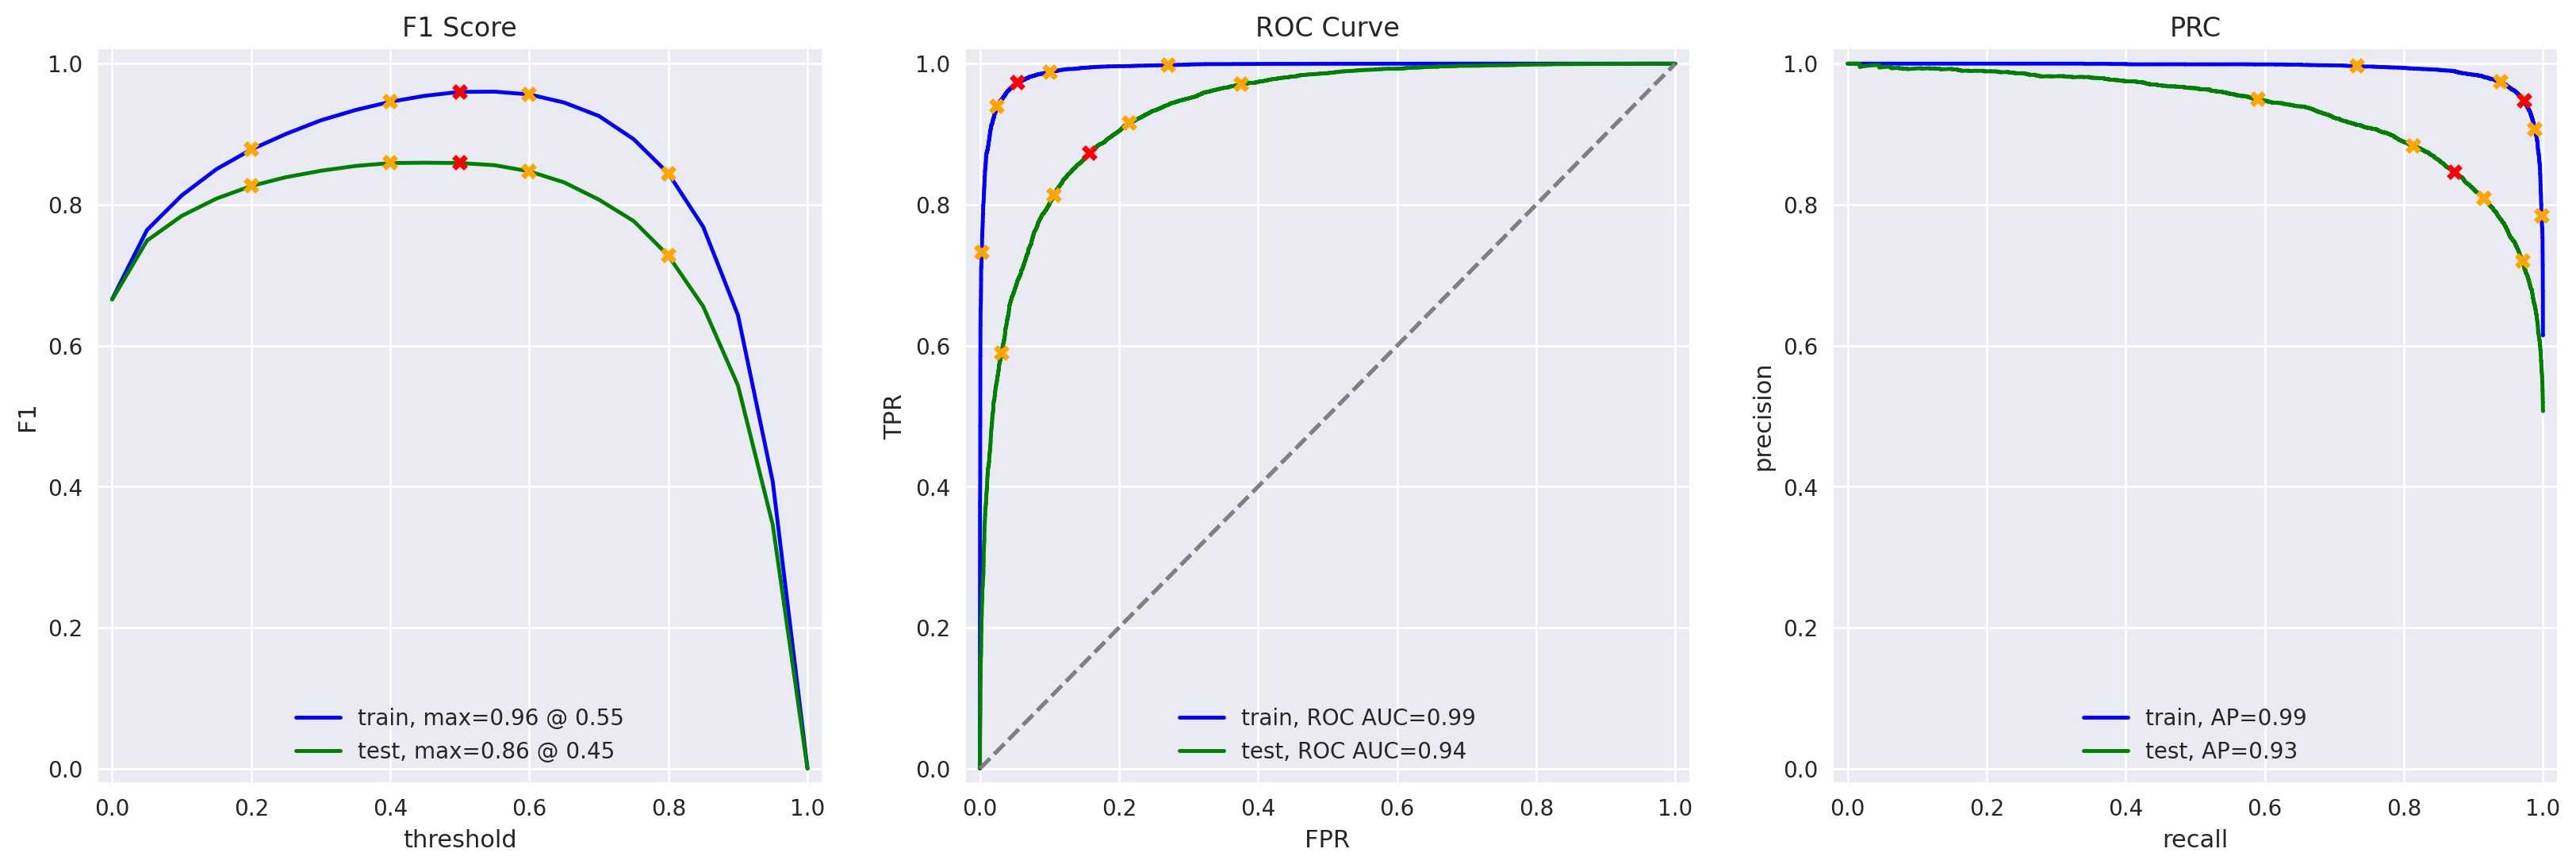

In [35]:
evaluate_model(model_4, X_train_tfidf_4, train_target, X_test_tfidf_4, test_target)

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Very good!     
</div>

###  Model 9 - BERT

#### Skipping for now since this environment doesn't support GPU usage

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
#def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#    ids_list = []
 #   attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
  #  max_length = 512

   # for input_text in df_reviews['review_norm']:
    #    ids = tokenizer.encode(
     #       input_text.lower(),
      #      add_special_tokens=True,
       #     max_length=max_length
       # )
       # padded = np.array(ids + [0]*(max_length - len(ids)))
       # attention_mask = np.where(padded != 0, 1, 0)
       # ids_list.append(padded)
       # attention_mask_list.append(attention_mask)
    
    #if force_device is not None:
     #   device = torch.device(force_device)
    #else:
     #   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#    model.to(device)
#    if not disable_progress_bar:
#        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

#    embeddings = []

#    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
 #       attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
  #      with torch.no_grad():            
#            model.eval()
 #           batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
  #      embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
   # return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Yes, Bert is a hard thing to handle, so we should use GPU for it. By the way, you can use Colab for your practice tasks. It has some free GPU.

</div>

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [36]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.lower()# <put here the same normalization logic as for the main dataset>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 2

In [37]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [38]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.51:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didnt expect the reboot to be so good writers really cared about the source material
0.40:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 4

In [39]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  i did not simply like it not my kind of movie
0.26:  well i was bored and felt asleep in the middle of the movie
0.61:  i was really fascinated with the movie
0.50:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.48:  i didnt expect the reboot to be so good writers really cared about the source material
0.61:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.24:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.73:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
    
Nice results! 
</div>


### Model 9

In [ ]:
#texts = my_reviews['review_norm']

#my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

#my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

#for i, review in enumerate(texts.str.slice(0, 100)):
    #print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

The Film Junky Union is requesting a service to filter and categorize movie reviews. After performing quick analysis of the source data, I immediately jumped into model building, training, and testing. I used a combination of different tokenization techniques and machine learning models to find out which would be the most accurate. Based on my testing, the most accurate tokenization and machine learning combination is to use nltk preprocessing with TF-IDF vectorization and train with a simple Logistic Regression model. This combination gave me F1 scores of 0.94 on the training set and 0.88 on the test set. After using this model with reviews that were hand written, the model performed exceedingly well, only misidentifying 1 review out of 8. 

Continued hyperparameter tuning and access to GPU hardware acceleration could help increase the model's accuracy and allow me to use BERT models as well, which could increase efficiency and accuracy.

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    

Excellent, thank you so much! 

</div>


# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions